### **Columbia University**
### **ECBM E4040 Neural Networks and Deep Learning. Fall 2021.**

## **Task 2: RNN application -- Tweet Sentiment Analysis**

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimenssionality redution. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## **Part 1 LSTM Encoder**

**TODO**: Create a single-layer LSTM network to classify tweets. Use one hot encoding to represent each word in the tweet. Set LSTM units to 100. Use Adam optimizer and set batch size to 64.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional). 

(tf.one_hot and Keras functional API may be useful).

In [3]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################

model = tf.keras.Sequential()

model.add(layers.Lambda(lambda x: tf.one_hot(x, *vocabulary.shape)))

# lookuptable = np.arange(*vocabulary.shape)
# model.add(layers.IntegerLookup(vocabulary=lookuptable, output_mode='one_hot'))

# model.add(layers.LSTM(128))
model.add(layers.LSTM(128, return_sequences=True))

# model.add(layers.Flatten())

model.add(layers.Dropout(0.6))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss = keras.losses.BinaryCrossentropy(), 
    optimizer = keras.optimizers.Adam(lr = 1e-3, decay = 1e-5), 
    metrics = ['accuracy']
)

model.fit(
    train_tweets, train_labels, 
    batch_size = 64, epochs = 10, 
    validation_data = (test_tweets, test_labels)
)

model.summary()


###################################################
# END TODO                                        #
###################################################

Epoch 1/10
938/938 [==============================] - 16s 13ms/step - loss: 0.5956 - accuracy: 0.6735 - val_loss: 0.5617 - val_accuracy: 0.7064
Epoch 2/10
938/938 [==============================] - 12s 12ms/step - loss: 0.5133 - accuracy: 0.7394 - val_loss: 0.5630 - val_accuracy: 0.7138
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4986 - accuracy: 0.7469 - val_loss: 0.5656 - val_accuracy: 0.7162
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4817 - accuracy: 0.7543 - val_loss: 0.5709 - val_accuracy: 0.7161
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4656 - accuracy: 0.7620 - val_loss: 0.5826 - val_accuracy: 0.7126
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4484 - accuracy: 0.7699 - val_loss: 0.6052 - val_accuracy: 0.7135
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4272 - accuracy: 0.7816 - val_loss: 0.6044 - val_accuracy:

## **Part 2: Embedding Lookup layer**

**Define an embedding layer**

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling.

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

**TODO**: Define a similar model as above with one change. Use an Embedding layer instead of one hot embedding. Also, write a custom training loop to train the model instead of using model.fit(). Writing a custom loop gives you complete control over how the model is trained. Refer to the link below.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

Report loss and accuracy for training and validation after each epoch. Also, display the loss value after every 400 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?


Solution:

In [6]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################

# model definition
model = tf.keras.Sequential()

model.add(layers.Input(shape=(20,)))

model.add(layers.Embedding(*vocabulary.shape,512))

model.add(layers.LSTM(128, return_sequences=True))

model.add(layers.Flatten())

model.add(layers.Dropout(0.6))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

optimizer = keras.optimizers.Adam(lr = 5e-4, decay = 1e-5)

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn = keras.losses.BinaryCrossentropy()


batch_size = 64
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((test_tweets, test_labels))
val_dataset = val_dataset.batch(batch_size)

# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(tf.reshape(y, [-1, 1]), logits)
    return loss_value


@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(tf.reshape(y, [-1, 1]), val_logits)


epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 400 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            # print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))




###################################################
# END TODO                                        #
###################################################

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 512)           3889664   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 128)           328192    
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2560)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2560)              10240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2561      
Total params: 4,230,657
Trainable params: 4,225,537
Non-trainable params: 5,120
________________________________________

## **TODO:**  **Visualize word vectors via tSNE**

First, you need to retrieve embedding matrix from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector.

And then, you should visualize some interesting word pairs in 2D panel. You may find scatter function in matplotlib.pyplot useful.

Hint: You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.

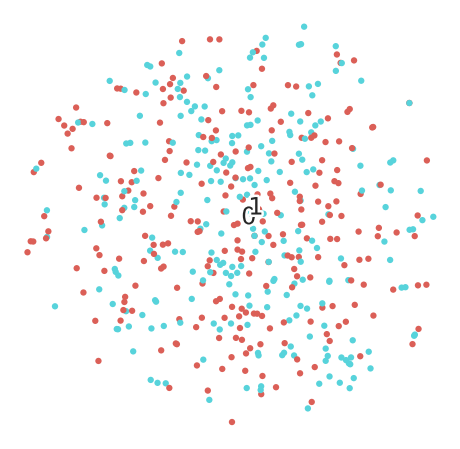

In [50]:
###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    # ax = plt.subplot(aspect='equal')
    ax = plt.subplot()
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

        
random_select = np.random.choice(train_tweets.shape[0], 500, replace=False)

x_subset = train_tweets[random_select]
x_subset = np.mean(model.layers[0](x_subset),axis=2)
# print(x_subset.shape)
# x_subset = tf.reshape(x_subset, [-1,512]).numpy()
# x_subset = x_subset.numpy()
# print(x_subset.shape)

y_subset = train_labels[random_select]
# y_subset = np.repeat(y_subset, 20)
# print(y_subset)
# print(y_subset.shape)


fashion_tsne = TSNE().fit_transform(x_subset)

# print(fashion_tsne.shape)

fashion_scatter(fashion_tsne, y_subset)



###################################################
# END TODO                                        #
###################################################